In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [124]:
# read in image with opencv
high_res_img = cv2.imread("imm.jpeg")
low_res_img = cv2.resize(high_res_img, (0,0), fx=0.1, fy=0.1, interpolation=cv2.INTER_CUBIC)
y_channel, i_channel, q_channel = cv2.split(cv2.cvtColor(low_res_img, cv2.COLOR_BGR2YCrCb))
img = y_channel


# get list of all patches
patches = []
window_size = 20
for i in range(0,img.shape[0]-window_size):
    for j in range(0,img.shape[1]-window_size):
        patch = img[i:i+window_size,j:j+window_size]
        patches.append(patch)
patches = np.array(patches)


downsampled_patches = []
for patch in patches:
    patch = cv2.resize(patch, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
    # now make it back to original size
    patch = cv2.resize(patch, (0,0), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    downsampled_patches.append(patch)

downsampled_patches = np.array(downsampled_patches)

print("patches.shape", patches.shape)
print("downsampled_patches.shape", downsampled_patches.shape)
    
           
        


patches.shape (11664, 20, 20)
downsampled_patches.shape (11664, 20, 20)


In [125]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (window_size, window_size, 1)

# Define the convolutional autoencoder model
def autoencoder_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    encoded = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)  # new layer

    # Decoder
    decoded = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(encoded)  # new layer
    decoded = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

    model = models.Model(inputs=inputs, outputs=decoded)
    return model


def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# Create the autoencoder model
model = autoencoder_model(input_shape)

# Compile the model with SSIM loss
model.compile(optimizer='adam', loss=ssim_loss, metrics=['accuracy'])

# Display the model architecture
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 20, 20, 1)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 20, 20, 16)        160       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 10, 10, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 10, 10, 32)        4640      
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 10, 10, 32)       9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_23 (Conv2D  (None, 10, 10, 16)       462

In [126]:
downsampled_patches = downsampled_patches.reshape((-1, window_size, window_size, 1))
patches = patches.reshape((-1, window_size, window_size, 1))

# normalize data
downsampled_patches = downsampled_patches / 255
patches = patches / 255
model.fit(downsampled_patches, patches, epochs=10, batch_size=32)



Epoch 1/10
365/365 [==============================] - 7s 16ms/step - loss: 0.1568 - accuracy: 0.8612
Epoch 2/10
365/365 [==============================] - 6s 15ms/step - loss: 0.0884 - accuracy: 0.8668
Epoch 3/10
365/365 [==============================] - 6s 17ms/step - loss: 0.0750 - accuracy: 0.8675
Epoch 4/10
365/365 [==============================] - 6s 16ms/step - loss: 0.0670 - accuracy: 0.8679
Epoch 5/10
365/365 [==============================] - 6s 16ms/step - loss: 0.0606 - accuracy: 0.8682
Epoch 6/10
365/365 [==============================] - 6s 16ms/step - loss: 0.0567 - accuracy: 0.8686
Epoch 7/10
365/365 [==============================] - 6s 15ms/step - loss: 0.0527 - accuracy: 0.8688
Epoch 8/10
365/365 [==============================] - 6s 16ms/step - loss: 0.0489 - accuracy: 0.8689
Epoch 9/10
365/365 [==============================] - 6s 15ms/step - loss: 0.0461 - accuracy: 0.8691
Epoch 10/10
365/365 [==============================] - 6s 16ms/step - loss: 0.0432 - accura

1/1 [==============================] - 0s 64ms/step


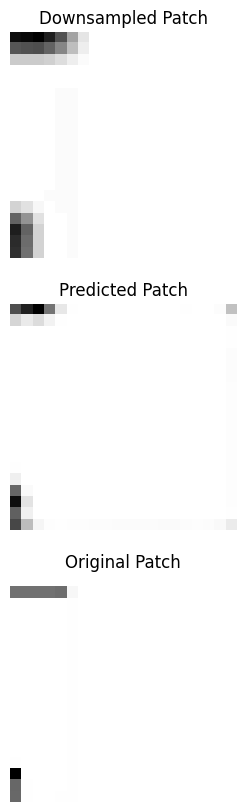

In [127]:
i = 99
sample_patch = downsampled_patches[i]

sample_patch = sample_patch.reshape((1, window_size, window_size, 1))

predicted_patch = model.predict(sample_patch)

predicted_patch = predicted_patch.reshape((window_size, window_size))

# Plot the original patch and the predicted patch and the original patch side by side
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
axes[0].imshow(sample_patch.reshape((window_size, window_size)), cmap='gray')
axes[0].set_title('Downsampled Patch')
axes[0].axis('off')
axes[1].imshow(predicted_patch, cmap='gray')
axes[1].set_title('Predicted Patch')
axes[1].axis('off')
axes[2].imshow(patches[i], cmap='gray')
axes[2].set_title('Original Patch')
axes[2].axis('off')

plt.show()


In [128]:
# Iterate through the image and generate super-resolution patches

# add a border of 5 pixels
# Constants
window = 5  # Original window size
scale_factor = 4  # Scaling factor for the super-resolution
stride = 3  # Stride for iteration

# Adding border and initializing SR image
img = cv2.copyMakeBorder(img, window, window, window, window, cv2.BORDER_CONSTANT, value=0)
SR_image = np.zeros((img.shape[0]*scale_factor, img.shape[1]*scale_factor))

# Initialize a list for each pixel to store values from different patches
SR_image_accumulator = [[[] for _ in range(img.shape[1]*scale_factor)] for _ in range(img.shape[0]*scale_factor)]

# Iterate through the image with a stride of 2 pixels
for i in range(0, img.shape[0]-window, stride):
  for j in range(0, img.shape[1]-window, stride):
    patch = img[i:i+window, j:j+window]
    patch = cv2.resize(patch, (window*scale_factor, window*scale_factor), interpolation=cv2.INTER_CUBIC)
    patch = patch.reshape((1, window*scale_factor, window*scale_factor, 1))
    patch = patch / 255

    prediction = model.predict(patch)

    prediction = prediction.reshape((window*scale_factor, window*scale_factor))  
    prediction = prediction * 255

    # Append the values of the patch to the corresponding pixels
    for di in range(window*scale_factor):
        for dj in range(window*scale_factor):
            SR_image_accumulator[i*scale_factor+di][j*scale_factor+dj].append(prediction[di, dj])

# Fill empty pixels with corresponding pixels from the upscaled low-res image
upscaled_low_res_img = cv2.resize(img, (img.shape[1]*scale_factor, img.shape[0]*scale_factor), interpolation=cv2.INTER_CUBIC)
for i in range(len(SR_image_accumulator)):
    for j in range(len(SR_image_accumulator[0])):
        if not SR_image_accumulator[i][j]:  # Check if the list is empty
            SR_image_accumulator[i][j].append(upscaled_low_res_img[i][j])

# Compute the average for each pixel from its accumulated values
for i in range(len(SR_image_accumulator)):
    for j in range(len(SR_image_accumulator[0])):
        SR_image[i][j] = sum(SR_image_accumulator[i][j]) / len(SR_image_accumulator[i][j])


1/1 [==============================] - 0s 9ms/step


In [129]:
img = img[window:-window, window:-window]
SR_image = SR_image[window_size:-window_size, window_size:-window_size]

In [130]:
# reshape color channels to be the same size as the SR image
i_channel_resized = cv2.resize(i_channel, (0,0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
q_channel_resized = cv2.resize(q_channel, (0,0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

stacked_channels = np.stack([SR_image, i_channel_resized, q_channel_resized], axis=2)

if stacked_channels.dtype != np.uint8:
    stacked_channels = stacked_channels.astype(np.uint8)

colored_SR_image = cv2.cvtColor(stacked_channels, cv2.COLOR_YCrCb2BGR)

In [131]:
low_res_img = cv2.resize(low_res_img, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)


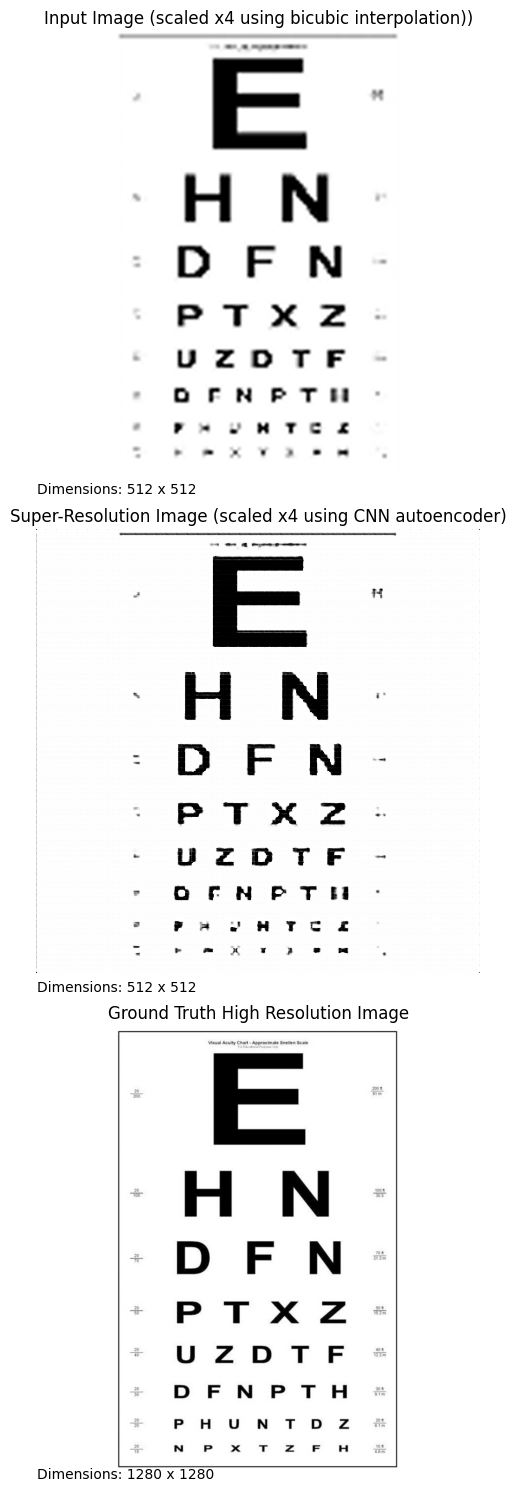

In [132]:
fig, axes = plt.subplots(3, 1, figsize=(8, 15))

axes[0].imshow(cv2.cvtColor(low_res_img, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'Input Image (scaled x{scale_factor} using bicubic interpolation))')
axes[0].axis('off')
axes[0].text(0, low_res_img.shape[0] + 20, f"Dimensions: {low_res_img.shape[0]} x {low_res_img.shape[1]}", ha='left')

axes[1].imshow(cv2.cvtColor(colored_SR_image, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Super-Resolution Image (scaled x{scale_factor} using CNN autoencoder)')
axes[1].axis('off')
axes[1].text(0, colored_SR_image.shape[0] + 20, f"Dimensions: {colored_SR_image.shape[0]} x {colored_SR_image.shape[1]}", ha='left')

axes[2].imshow(cv2.cvtColor(high_res_img, cv2.COLOR_BGR2RGB))
axes[2].set_title('Ground Truth High Resolution Image')
axes[2].axis('off')
axes[2].text(0, high_res_img.shape[0] + 20, f"Dimensions: {high_res_img.shape[0]} x {high_res_img.shape[1]}", ha='left')

plt.tight_layout()
plt.show()


In [133]:
output_file = "sr_image_eye.jpg"
cv2.imwrite(output_file, colored_SR_image)


True